# Evaluate [the nn4 small model](https://github.com/iwantooxxoox/Keras-OpenFace/blob/master/Keras-openface-convertion.ipynb) in keras

In [1]:
! which python3

/home/coep/venv/py3-tflowcpu/bin/python3


In [2]:
! python --version

Python 3.6.7


In [3]:
from keras.models import load_model
from keras.utils import CustomObjectScope
import tensorflow as tf

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [27]:
# Align images

BASE_PATH = '/home/coep/pkm/datasets/'
VGG_PATH = 'VGG2/test/'
cls_list = list(os.listdir(BASE_PATH + VGG_PATH))
cls_list = cls_list[:4]



# PLOTS for facescrub aligned images

In [4]:
with CustomObjectScope({'tf': tf}):
    model = load_model('/home/coep/pkm/Keras-OpenFace/py3model/nn4.small2.lrn.h5')
    
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 48, 48, 64)   256         conv1[0][0]                      
_____________________________________

/home/coep/venv/py3-tflowcpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
FSCR_PATH = '/home/coep/pkm/datasets/facescrub_aligned/'
class_list = list(os.listdir(FSCR_PATH))
class_list = class_list[:4]
class_list

['Jonathan_Sadowski', 'Alley_Mills', 'Freddy_Prinze_Jr.', 'Fran_Drescher']

In [18]:
img_d = dict()

for clss in class_list:
    img_d[clss] = []
    allfl = os.listdir(FSCR_PATH + clss + '/')
    for fle in allfl:
        if fle.endswith('.png'):
            imgg = cv2.imread(FSCR_PATH + clss + '/' + fle, 1)
            imgg = imgg[...,::-1]
            imgg = cv2.resize(imgg, (96,96))
            imgg = np.around(imgg/255.0, decimals=12)
            img_d[clss].append(imgg)
            
img_d.keys()

dict_keys(['Jonathan_Sadowski', 'Alley_Mills', 'Freddy_Prinze_Jr.', 'Fran_Drescher'])

# Jonathan_Sadowski

In [20]:
len(img_d["Jonathan_Sadowski"])

162

In [21]:
y = model.predict_on_batch(np.array(img_d["Jonathan_Sadowski"]))
y.shape

(162, 128)

In [23]:
type(y)
y[1,:].shape
avgem = np.average(y, axis=0).reshape(1,128)

<function matplotlib.pyplot.show(*args, **kw)>

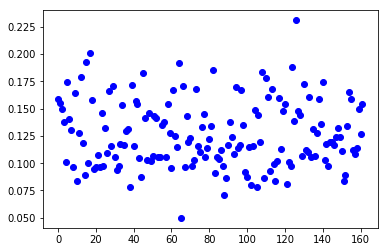

In [24]:
avgem = np.average(y, axis=0).reshape(1,128)
dists = [np.sqrt(np.abs(np.sum(np.square(y[i, :].reshape(1,128) - avgem)))) for i in range(162)]
plt.plot(range(162), dists, 'bo')
plt.show

# Distances from their own average

In [19]:
embs = dict()
avgs = dict()
dists = dict()
embs[class_list[3]] = model.predict_on_batch(np.array(img_d[class_list[3]]))
avgs[class_list[3]] = np.average(embs[class_list[3]], axis=0).reshape(1,128)

for clss in class_list[:3]:
    embs[clss] = model.predict_on_batch(np.array(img_d[clss]))
    avgs[clss] = np.average(embs[clss], axis=0).reshape(1,128)
    dists[clss] = [np.sqrt(np.abs(np.sum(np.square(embs[clss][i, :].reshape(1,128) - avgs[class_list[3]])))) for i in range(len(img_d[clss]))]
    

<function matplotlib.pyplot.show(*args, **kw)>

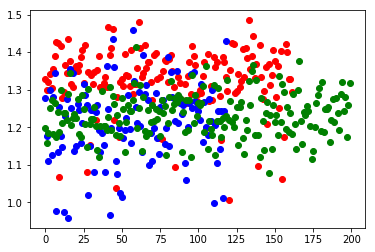

In [20]:
clr = ['ro', 'bo', 'go', 'yo']
for _, clss in enumerate(class_list[:3]):
    plt.plot(range(len(dists[clss])), dists[clss], clr[_])
    #plt.hold(True)
plt.show

# VGG2

In [28]:
class_list = ['n000001', 'n000009', 'n000029', 'n000078']
VGG_PATH = 'VGG2/test/'
import pre_proc as pp

In [29]:
img_d = dict()

for clss in class_list:
    img_d[clss] = []
    allfl = os.listdir(BASE_PATH + VGG_PATH + clss + '/')
    for fle in allfl:
        imgg = cv2.imread(BASE_PATH + VGG_PATH + clss + '/' + fle, 1)
        imgg = imgg[...,::-1]
        _, imgg = pp.face_crop(imgg, affine=True)
        if _:
            imgg = cv2.resize(imgg, (96,96))
            imgg = np.around(imgg/255.0, decimals=12)
            img_d[clss].append(imgg)
img_d.keys()

dict_keys(['n000001', 'n000009', 'n000029', 'n000078'])

In [30]:
def plot_avgdist(img_d, use_avg=False, avg=None):
    embs = dict()
    avgs = dict()
    dists = dict()

    for clss in class_list:
        embs[clss] = model.predict_on_batch(np.array(img_d[clss]))
        avgs[clss] = np.average(embs[clss], axis=0).reshape(1,128)
        if not use_avg:
            dists[clss] = [np.sqrt(np.abs(np.sum(np.square(embs[clss][i, :].reshape(1,128) - avgs[clss])))) for i in range(len(img_d[clss]))]
        else:
            dists[clss] = [np.sqrt(np.abs(np.sum(np.square(embs[clss][i, :].reshape(1,128) - avg)))) for i in range(len(img_d[clss]))]
    clr = ['ro', 'bo', 'go', 'yo']
    for _, clss in enumerate(class_list):
        plt.plot(range(len(dists[clss])), dists[clss], clr[_])
        #plt.hold(True)
    plt.show

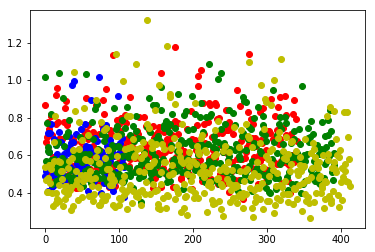

In [34]:
# Distances of VGG2 classes from their won average
plot_avgdist(img_d)

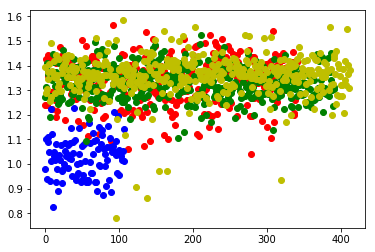

In [33]:
plot_avgdist(img_d, use_avg=True, avg=avgs["Fran_Drescher"])